# Exploring the Architecture of matplotlib

In the following sections of this IPython Notebook we will investigate different aspects of matplotlib's architecture. These include:
 * modules and import graphs
 * execution flow
 * the objects created by the pyplot scripting layer

Before we start, though, let's get things warmed up:

In [1]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline

Now we'll bring in the modules we'll be using in this notebook:

In [3]:
!pip install pycallgraph

  Created wheel for pycallgraph: filename=pycallgraph-1.0.1-py3-none-any.whl size=36104 sha256=abfaee73b342ada5577b21a0a814bfc77a0904209554daafe6284cd5e754b901
  Stored in directory: /root/.cache/pip/wheels/2c/3d/e8/6f0aaf3d5ece26c5ab6ab37062d8470b612ac2c2e259717d25
Successfully built pycallgraph


In [4]:
from glob import glob
from modulefinder import Module
from modulefinder import ModuleFinder
from os.path import dirname
from pprint import pprint
import sys
import trace
import urllib.request

import matplotlib.pyplot as plt
from IPython.core.display import Image 

from pycallgraph import Config 
from pycallgraph import GlobbingFilter 
from pycallgraph import PyCallGraph
from pycallgraph.output import GraphvizOutput

Now let's get some code we created espeically for this notebook:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Modules and matplotlib import graphs

In this section, will will explore the architecture of matplotlib using the NetworkX library in conjunction with matplotlib itself. First, though, let's take a look at matplotlib's package structure.

### Modules

We can get a first glimps of the structure by looking at the package directory. IPython actually supports the ``ls -al`` shell command, but we're going to need something a bit more flexible, so let's import a convenience function we defined in the ``modutil`` module:

In [ ]:
libdir = "../../.venv-mmpl/lib/python3.4/site-packages/matplotlib"
ls(libdir)

total 15400
-rw-r--r--   1 oubiwann  staff   94005 May  6 10:13 _cm.py
-rw-r--r--   1 oubiwann  staff   90077 May  6 10:13 _mathtext_data.py
-rw-r--r--   1 oubiwann  staff    3506 May  6 10:13 _pylab_helpers.py
-rw-r--r--   1 oubiwann  staff   16200 May  6 10:13 afm.py
-rw-r--r--   1 oubiwann  staff   44129 May  6 10:13 animation.py
-rw-r--r--   1 oubiwann  staff   41588 May  6 10:13 artist.py
drwxr-xr-x   7 oubiwann  staff     238 May  6 10:13 axes
-rw-r--r--   1 oubiwann  staff   80644 May  6 10:13 axis.py
-rw-r--r--   1 oubiwann  staff  106046 May  6 10:13 backend_bases.py
drwxr-xr-x  41 oubiwann  staff    1394 May  6 10:13 backends
-rw-r--r--   1 oubiwann  staff   15695 May  6 10:13 bezier.py
-rw-r--r--   1 oubiwann  staff   11636 May  6 10:13 blocking_input.py
-rw-r--r--   1 oubiwann  staff   70573 May  6 10:13 cbook.py
-rw-r--r--   1 oubiwann  staff   11669 May  6 10:13 cm.py
-rw-r--r--   1 oubiwann  staff   63102 May  6 10:13 collections.py
-rw-r--r--   1 oubiwann  staff   49307

Let's get a cleaner view, though. Here are all the top-level matplotlib modules:

In [ ]:
toplevel = glob(libdir + "/*.py")
modules = ["matplotlib" + x.split(libdir)[1] for x in toplevel]
len(modules)

59

In [ ]:
pprint(modules)

['matplotlib/__init__.py',
 'matplotlib/_cm.py',
 'matplotlib/_mathtext_data.py',
 'matplotlib/_pylab_helpers.py',
 'matplotlib/afm.py',
 'matplotlib/animation.py',
 'matplotlib/artist.py',
 'matplotlib/axis.py',
 'matplotlib/backend_bases.py',
 'matplotlib/bezier.py',
 'matplotlib/blocking_input.py',
 'matplotlib/cbook.py',
 'matplotlib/cm.py',
 'matplotlib/collections.py',
 'matplotlib/colorbar.py',
 'matplotlib/colors.py',
 'matplotlib/container.py',
 'matplotlib/contour.py',
 'matplotlib/dates.py',
 'matplotlib/docstring.py',
 'matplotlib/dviread.py',
 'matplotlib/figure.py',
 'matplotlib/finance.py',
 'matplotlib/font_manager.py',
 'matplotlib/fontconfig_pattern.py',
 'matplotlib/gridspec.py',
 'matplotlib/hatch.py',
 'matplotlib/image.py',
 'matplotlib/legend.py',
 'matplotlib/legend_handler.py',
 'matplotlib/lines.py',
 'matplotlib/markers.py',
 'matplotlib/mathtext.py',
 'matplotlib/mlab.py',
 'matplotlib/mpl.py',
 'matplotlib/offsetbox.py',
 'matplotlib/patches.py',
 'matplotl

And these are matplotlib's subpackages:

In [ ]:
modfile = "/__init__.py"
subs = [dirname(x) for x in glob(libdir + "/*" + modfile)]
pprint(["matplotlib" + x.split(libdir)[1] for x in subs])

['matplotlib/axes',
 'matplotlib/backends',
 'matplotlib/compat',
 'matplotlib/delaunay',
 'matplotlib/projections',
 'matplotlib/sphinxext',
 'matplotlib/style',
 'matplotlib/testing',
 'matplotlib/tests',
 'matplotlib/tri']


Let's take a peek into some of these:

In [ ]:
ignore_output =[ls(libdir + x) for x in ["/backends", "/axes", "/projections"]]

total 6248
-rw-r--r--   1 oubiwann  staff    21106 May  6 10:13 backend_agg.py
-rw-r--r--   1 oubiwann  staff    17494 May  6 10:13 backend_cairo.py
-rw-r--r--   1 oubiwann  staff     9980 May  6 10:13 backend_cocoaagg.py
-rw-r--r--   1 oubiwann  staff    16712 May  6 10:13 backend_gdk.py
-rw-r--r--   1 oubiwann  staff    37356 May  6 10:13 backend_gtk.py
-rw-r--r--   1 oubiwann  staff    30540 May  6 10:13 backend_gtk3.py
-rw-r--r--   1 oubiwann  staff     3815 May  6 10:13 backend_gtk3agg.py
-rw-r--r--   1 oubiwann  staff     2321 May  6 10:13 backend_gtk3cairo.py
-rw-r--r--   1 oubiwann  staff     4354 May  6 10:13 backend_gtkagg.py
-rw-r--r--   1 oubiwann  staff     2348 May  6 10:13 backend_gtkcairo.py
-rw-r--r--   1 oubiwann  staff    15754 May  6 10:13 backend_macosx.py
-rw-r--r--   1 oubiwann  staff     5673 May  6 10:13 backend_mixed.py
-rw-r--r--   1 oubiwann  staff     9518 May  6 10:13 backend_nbagg.py
-rw-r--r--   1 oubiwann  staff    94712 May  6 10:13 backend_pdf.py
-rw-

matplotlib has an architecture that conceptually groups areas of functionality into the following layers:
 * scripting
 * artist
 * backend
 
There's nothing in matplotlib that correlates modules and subpackages to these conceptual layers, so we created one in a module used by this notebook:


In [ ]:
pprint(matplotlib_groupings)

{'artist layer': ['matplotlib.afm',
                  'matplotlib.animation',
                  'matplotlib.artist',
                  'matplotlib.ax',
                  'matplotlib.container',
                  'matplotlib.contour',
                  'matplotlib.figure',
                  'matplotlib.gridspec',
                  'matplotlib.hatch',
                  'matplotlib.image',
                  'matplotlib.legend',
                  'matplotlib.lines',
                  'matplotlib.marker',
                  'matplotlib.offset',
                  'matplotlib.patches',
                  'matplotlib.path',
                  'matplotlib.projection',
                  'matplotlib.quiver',
                  'matplotlib.sankey',
                  'matplotlib.scale',
                  'matplotlib.spines',
                  'matplotlib.stackplot',
                  'matplotlib.streamplot',
                  'matplotlib.table',
                  'matplotlib.text',
                  'm

As you may notice, not all of the strings in the key/list pairs match exactly to matplotlib's modules or subpackages. That's because these strings are used to match beginnings of strings. Their intended use is in a call such as ``x.startswith(mod_name_part)``.

We will use this information later when building structured graphs of matplotlib imports, but for now this offers additional insight into how one can view the Python modules which comprise matplotlib.

### A Simple Script

We've got a simple matplotlib script that's in the ``./scripts`` directory. It has the following contents:

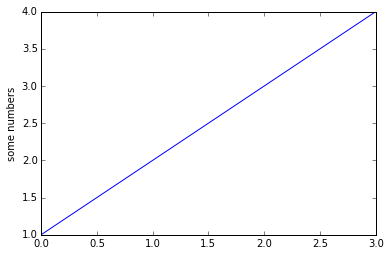

In [ ]:
#! /usr/bin/env python3.4
import matplotlib.pyplot as plt

def main () -> None:
    plt.plot([1,2,3,4])
    plt.ylabel('some numbers')
    plt.savefig('simple-line.png')

if __name__ == '__main__':
    main()

Super easy. But the purpose of this isn't to demonstrate something impressive with matplotlib. Rather, as we dig into the matplotlib modules, and in this case explore the module dependencies for our script, we want the simplest case possible so that we can focus on out goal: understanding how it all hooks up.

### ``ModuleFinder``

We'd like to see all the matplotlib modules that are imported just to do this simple script. There's a great Python module for just this sort of task: ``ModuleFinder``:

In [ ]:
finder = ModuleFinder()
finder.run_script('../scripts/simple-line.py')

Now, the problem with this, is that it's going to pull in *every* dependency for every library used. We're going to see ``matplotlib``, ``numpy``, the Python standard library, etc. Let's just take a look at the module count, and not display all of them:

In [ ]:
len(finder.modules)

1068

So we're going to need to do some customization...

### ``CustomFinder``

To do this, we're going to have to override methods that aren't part of the public API. In particular, we're going to want to get our mits into ``ModuleFinder.import_hook``. The reason for this is that we don't want to have the finder digging into modules we don't care about -- before it imports them, let's do a check, and only continue if everything looks okay.

Let's start with a simple subclass:

In [ ]:
class CustomFinder(ModuleFinder):

    def __init__(self, include:list, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cf_include = include

    def matches(self, name:str) -> bool:
        if True in [name.startswith(x) for x in self.cf_include]:
            return True
        return False
    
    def import_hook(self, name:str, caller:Module=None, fromlist:list=None,
                    level:int=-1) -> Module:
        if self.matches(name):
            super().import_hook(name, caller, fromlist, level)

Let's give this a try, passing a list of strings that module names can start with (just the ones we're interested in):

In [ ]:
finder = CustomFinder(["matpl", "mpl"])
finder.run_script('../scripts/simple-line.py')
len(finder.modules)

65

That's more like it! Since it's not 1000s of modules, let's take a peek:

In [ ]:
finder.modules.keys()

dict_keys(['matplotlib.widgets', 'matplotlib.type1font', 'matplotlib.bezier', 'matplotlib.patches', 'matplotlib.docstring', 'matplotlib.scale', 'matplotlib.contour', 'matplotlib.ft2font', '__main__', 'matplotlib.ttconv', 'matplotlib.axes', 'matplotlib.legend_handler', 'matplotlib.compat', 'matplotlib.markers', 'matplotlib.offsetbox', 'matplotlib.fontconfig_pattern', 'matplotlib.gridspec', 'matplotlib._mathtext_data', 'matplotlib.rcsetup', 'matplotlib._pylab_helpers', 'matplotlib.legend', 'matplotlib.backends.backend_agg', 'matplotlib._path', 'matplotlib.mlab', 'matplotlib.lines', 'matplotlib.ticker', 'matplotlib._image', 'matplotlib.style', 'matplotlib.textpath', 'matplotlib.backends', 'matplotlib.backends.backend_svg', 'matplotlib.backends.backend_webagg_core', 'matplotlib.figure', 'matplotlib.artist', 'matplotlib.hatch', 'matplotlib.texmanager', 'matplotlib.text', 'matplotlib.backend_bases', 'matplotlib.container', 'matplotlib.compat.subprocess', 'matplotlib.pyplot', 'matplotlib._cnt

We've created a custom finder very similar to the one above in the ``modfind`` module for this notebook. Try it out:

In [ ]:
finder = modfind.CustomFinder()
finder.run_script('../scripts/simple-line.py')
len(finder.modules)

62

As you can see, the loaded finder is a little more strict, having 3 fewer modules.

Okay, we've got our data. It's time to start gaining some insight ...

### Visualizing Dependency Graphs

In order to build a good picture of what we're looking at, we're going to want to have connections between modules (which modules import other modules), weighted values (which modules get imported the most), and node colors (which modules are more closely related to other modules). We've created a class that tracks all this data (as well as creating an instance of our custom finder).

Using this module will allow us to jump into the bigger-picture analysis more quickly, since we won't have to build up everthing from scratch in this notebook. However, you should definitely take a look at the code there for a deeper understanding of what's going on.

Let's take a look at these modules using our module grapher:

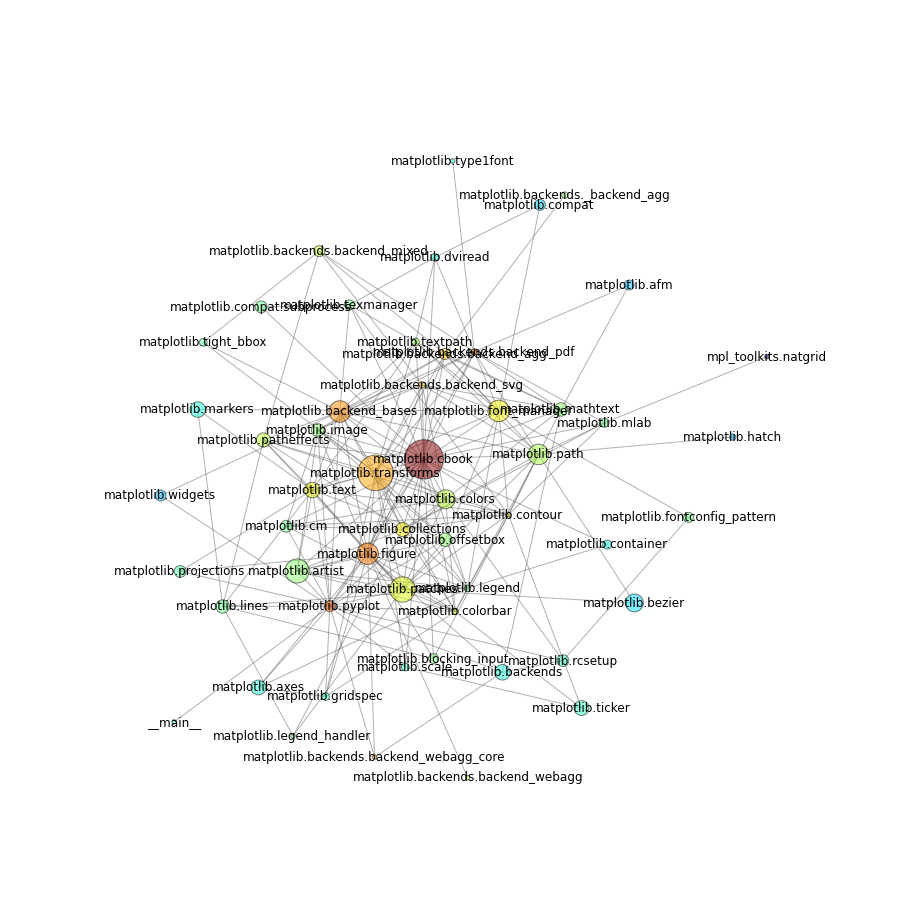

In [ ]:
grapher = modgraph.ModGrapher(
    source='../scripts/simple-line.py',
    layout='neato')
grapher.render()

Well, that's a bit of a mess. Not so "neato". Usig the ``dot`` layout is worse. Let's try ``twopi``:

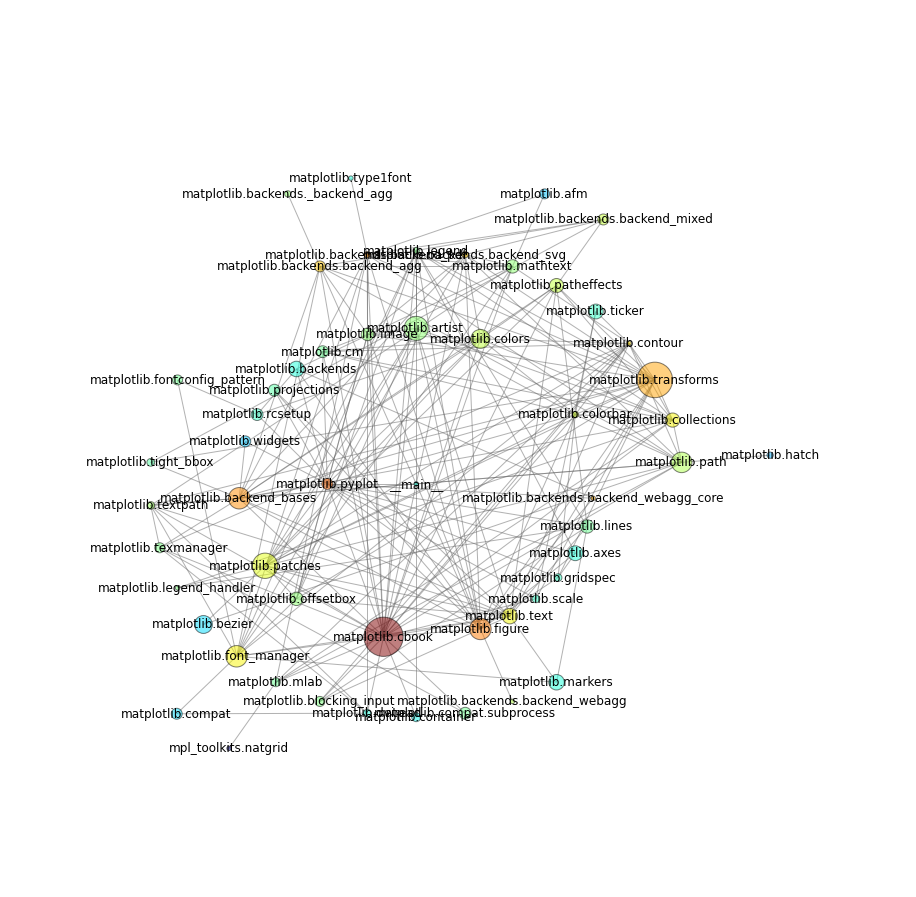

In [ ]:
grapher.render(layout="twopi")

That's a little bit better, but we're still not that much closer to seeing some structure. If we turn off the lables, we might get a better sense of things:

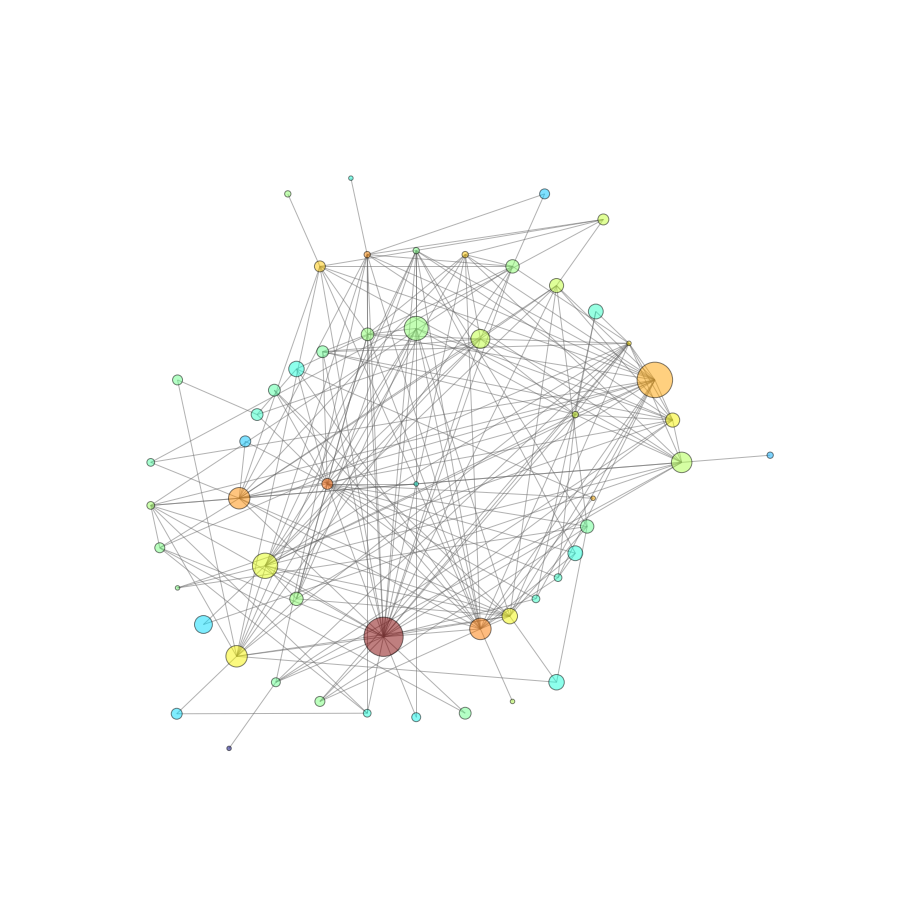

In [ ]:
grapher.render(layout="twopi", labels=False)

The way things are colored right now is fairly highly tweaked in the custom class: a combination of the [Levenshtein distance](http://en.wikipedia.org/wiki/Levenshtein_distance) of the module name and the [valency](http://en.wikipedia.org/wiki/Degree_(graph_theory)) of the given node. In other words, nodes with similar names and numbers of connections are closer in color. It's okay for a start (and kind of fun). But we could do better.

A quick thing to try would be to reduce the total number of modules we're looking at by grouping via submodules. For instance, all ``matplotlib.backend.*`` modules would be grouped with ``matplotlib.backend``. Out little custom module finder has a mode for this: "simple":

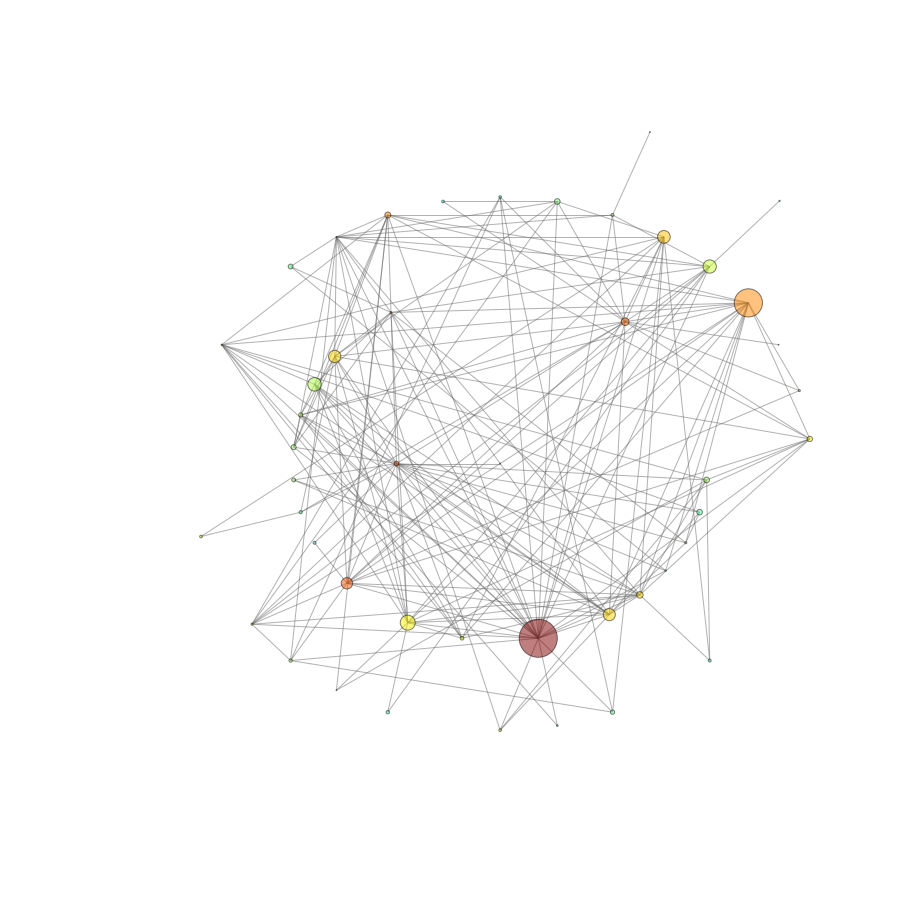

In [ ]:
grapher.render(layout="twopi", labels=False, mode="simple")

That's a *little* better, but I don't think we've really seen any structure revealed over what was visible in the previous rendering.

### Defining Structures

What we'd really like is a graph that showed how groups of modules connect. That's not an emergent property of the system itself, so it requires some manual work. As mentioned in this previous sections, the ``modgraph`` module defines the relationships of the top-level matplotlib modules with regard to the higher-level, conceptual architecture of matplotlib.

Let's re-render using a mode which takes advantage of this data structure:

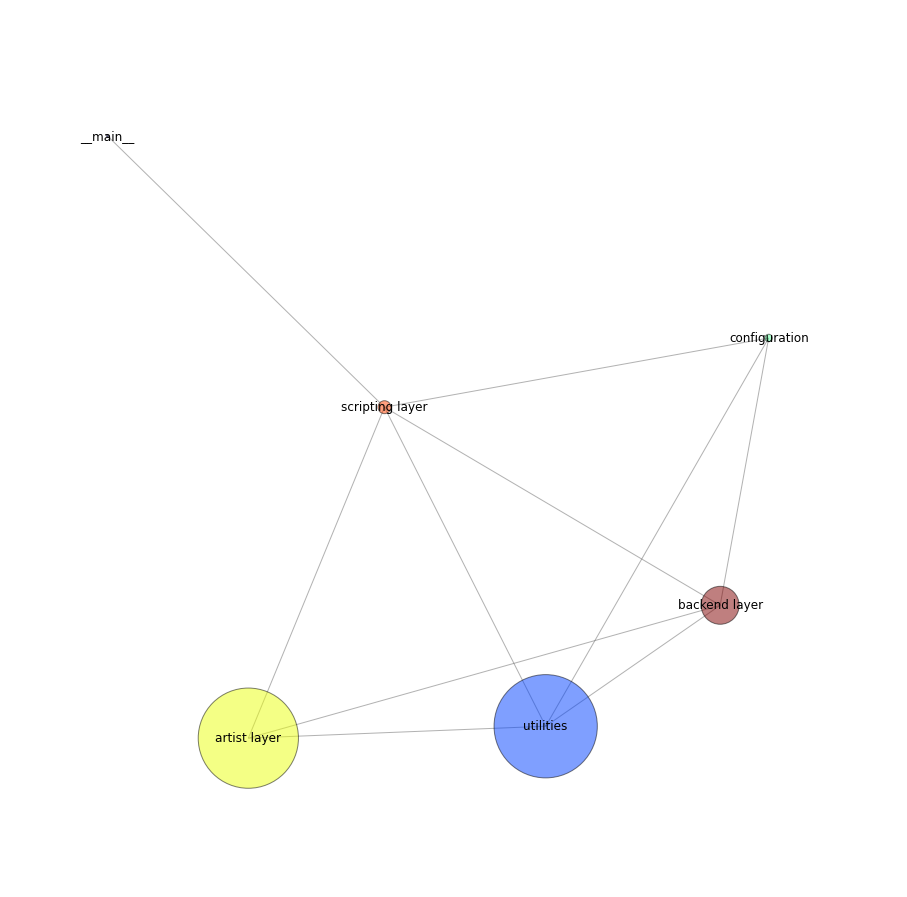

In [ ]:
grapher.render(layout="neato", labels=True, mode="reduced-structure")

This definitely simplifies things! But if we can combine this with the simple mode, it might help us better see how the individual components are related:

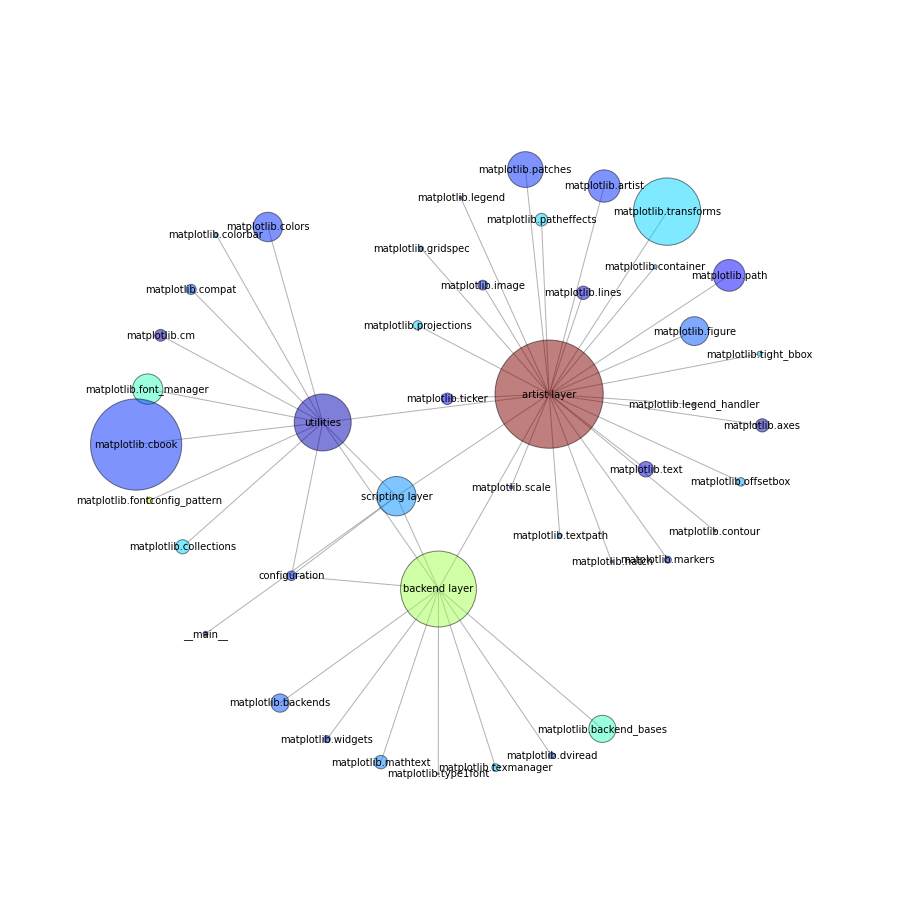

In [ ]:
grapher.render(layout="neato", labels=True, mode="simple-structure")

Now we're getting somewhere. What about with the full set of modules?

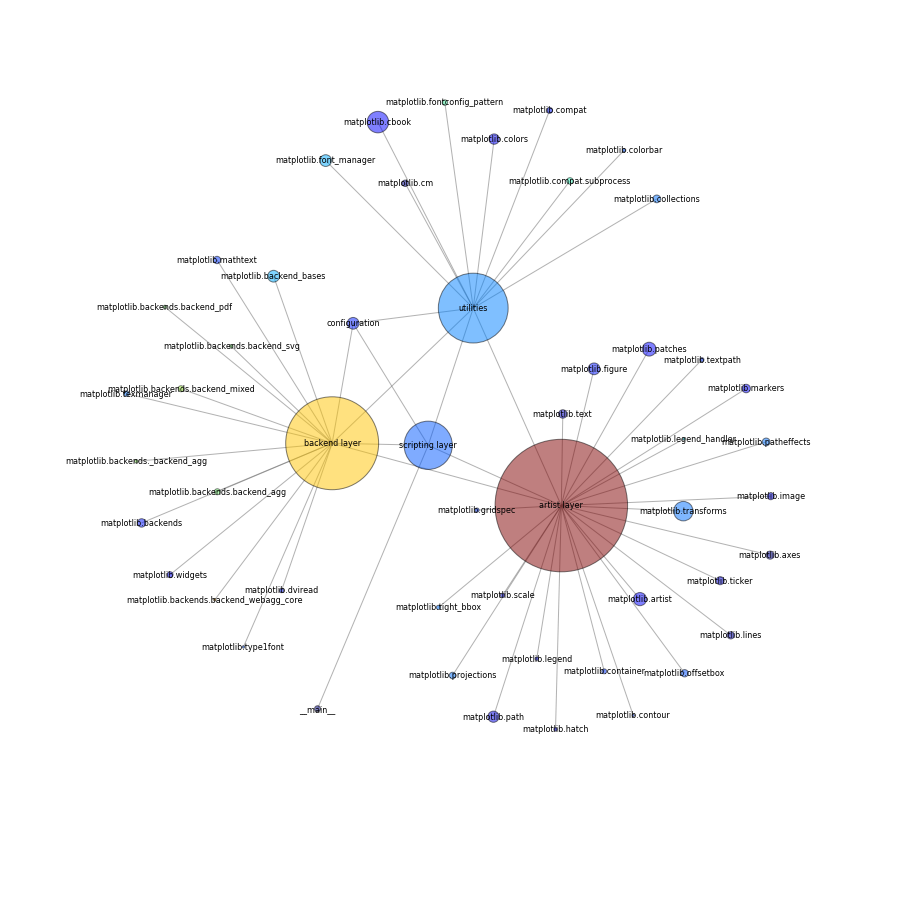

In [ ]:
grapher.render(layout="neato", labels=True, mode="full-structure")

And there you have it: the architecture of matplotlib from the perspective of a simple plotting script, and the imports that said script causes to occur.

## Execution flow in matplotlib

We've explored how imports cascade out into all the parts of matplotlib for our script. Next, let's actually look at what gets *called*.

Fore quick reference, here's the code for the simple script we created above:

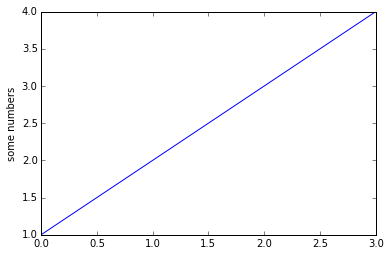

In [ ]:
#! /usr/bin/env python3.4
import matplotlib.pyplot as plt

def main () -> None:
    plt.plot([1,2,3,4])
    plt.ylabel('some numbers')
    plt.savefig('simple-line.png')

if __name__ == '__main__':
    main()

Now we will step through this on bit at a time:

In [ ]:
plt.rcParams['backend']

'module://IPython.kernel.zmq.pylab.backend_inline'

In [ ]:
plt._backend_mod.__name__

'IPython.kernel.zmq.pylab.backend_inline'

In [ ]:
plt._show

<function IPython.kernel.zmq.pylab.backend_inline.show>

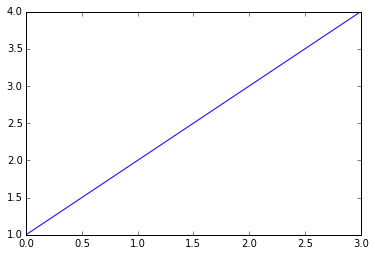

In [ ]:
plt.plot([1,2,3,4])

In [ ]:
plt.get_current_fig_manager()

In [ ]:
plt.get_current_fig_manager().canvas

In [ ]:
plt.get_current_fig_manager().canvas.figure

Or we can just use the ``pyplot`` utility functions:

In [ ]:
plt.gcf()

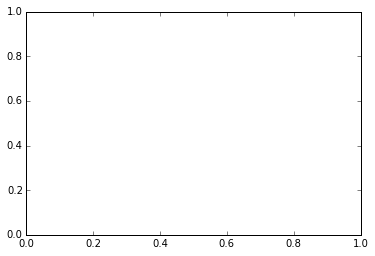

In [ ]:
plt.gca()

[]

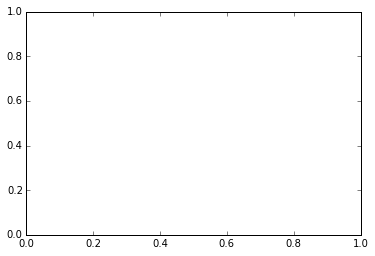

In [ ]:
plt.gca().lines

''

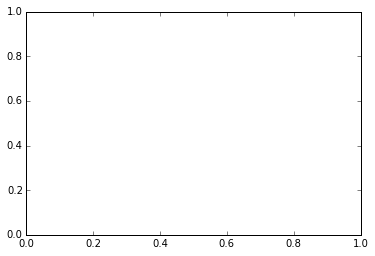

In [ ]:
plt.gca().get_ylabel()

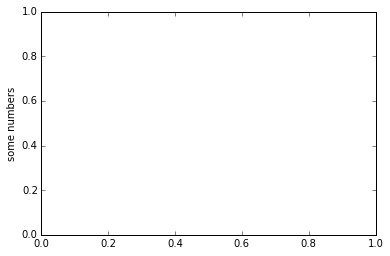

In [ ]:
plt.ylabel('some numbers')

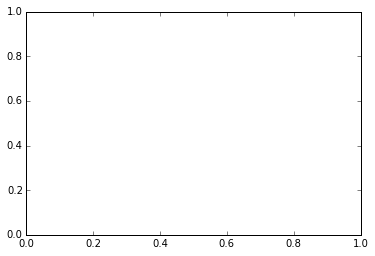

In [ ]:
print(plt.gca().get_ylabel())

Let's clean up from any previous runs:

In [ ]:
image_file = "simple-line.png"
if os.path.exists(image_file):
    rm(image_file)

In [ ]:
if os.path.exists(image_file):
    ls("*.png")

Finally, we can save our image:

In [ ]:
plt.savefig(image_file)

In [ ]:
if os.path.exists(image_file):
    ls("*.png")

-rw-r--r--  1 oubiwann  staff  1205 May  6 10:26 simple-line.png


## Callgraphs

[Note: the following section is experimental; pycallgraph is not returning everything it should for matplotlib.]

The next thing we'd like to look at is the call graph for our simple matplotlib script.

Before we dive into that, though, let's look at a simple example using the Python standard library only. Let's go with an old standard:

In [ ]:
def hello_world():
    print("Hello, World!")

Now, let's generate a call graph for this function, and then display it:

Hello, World!


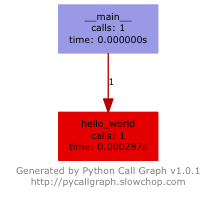

In [ ]:
config = Config(groups=False, trace_filter=None)
output = output=GraphvizOutput(output_file='callgraph.png')

with PyCallGraph(config=config, output=output):
    hello_world()
    
Image(filename='callgraph.png') 

Pretty simple, eh? Not too much information there to ponder. Let's try something a little more involved:

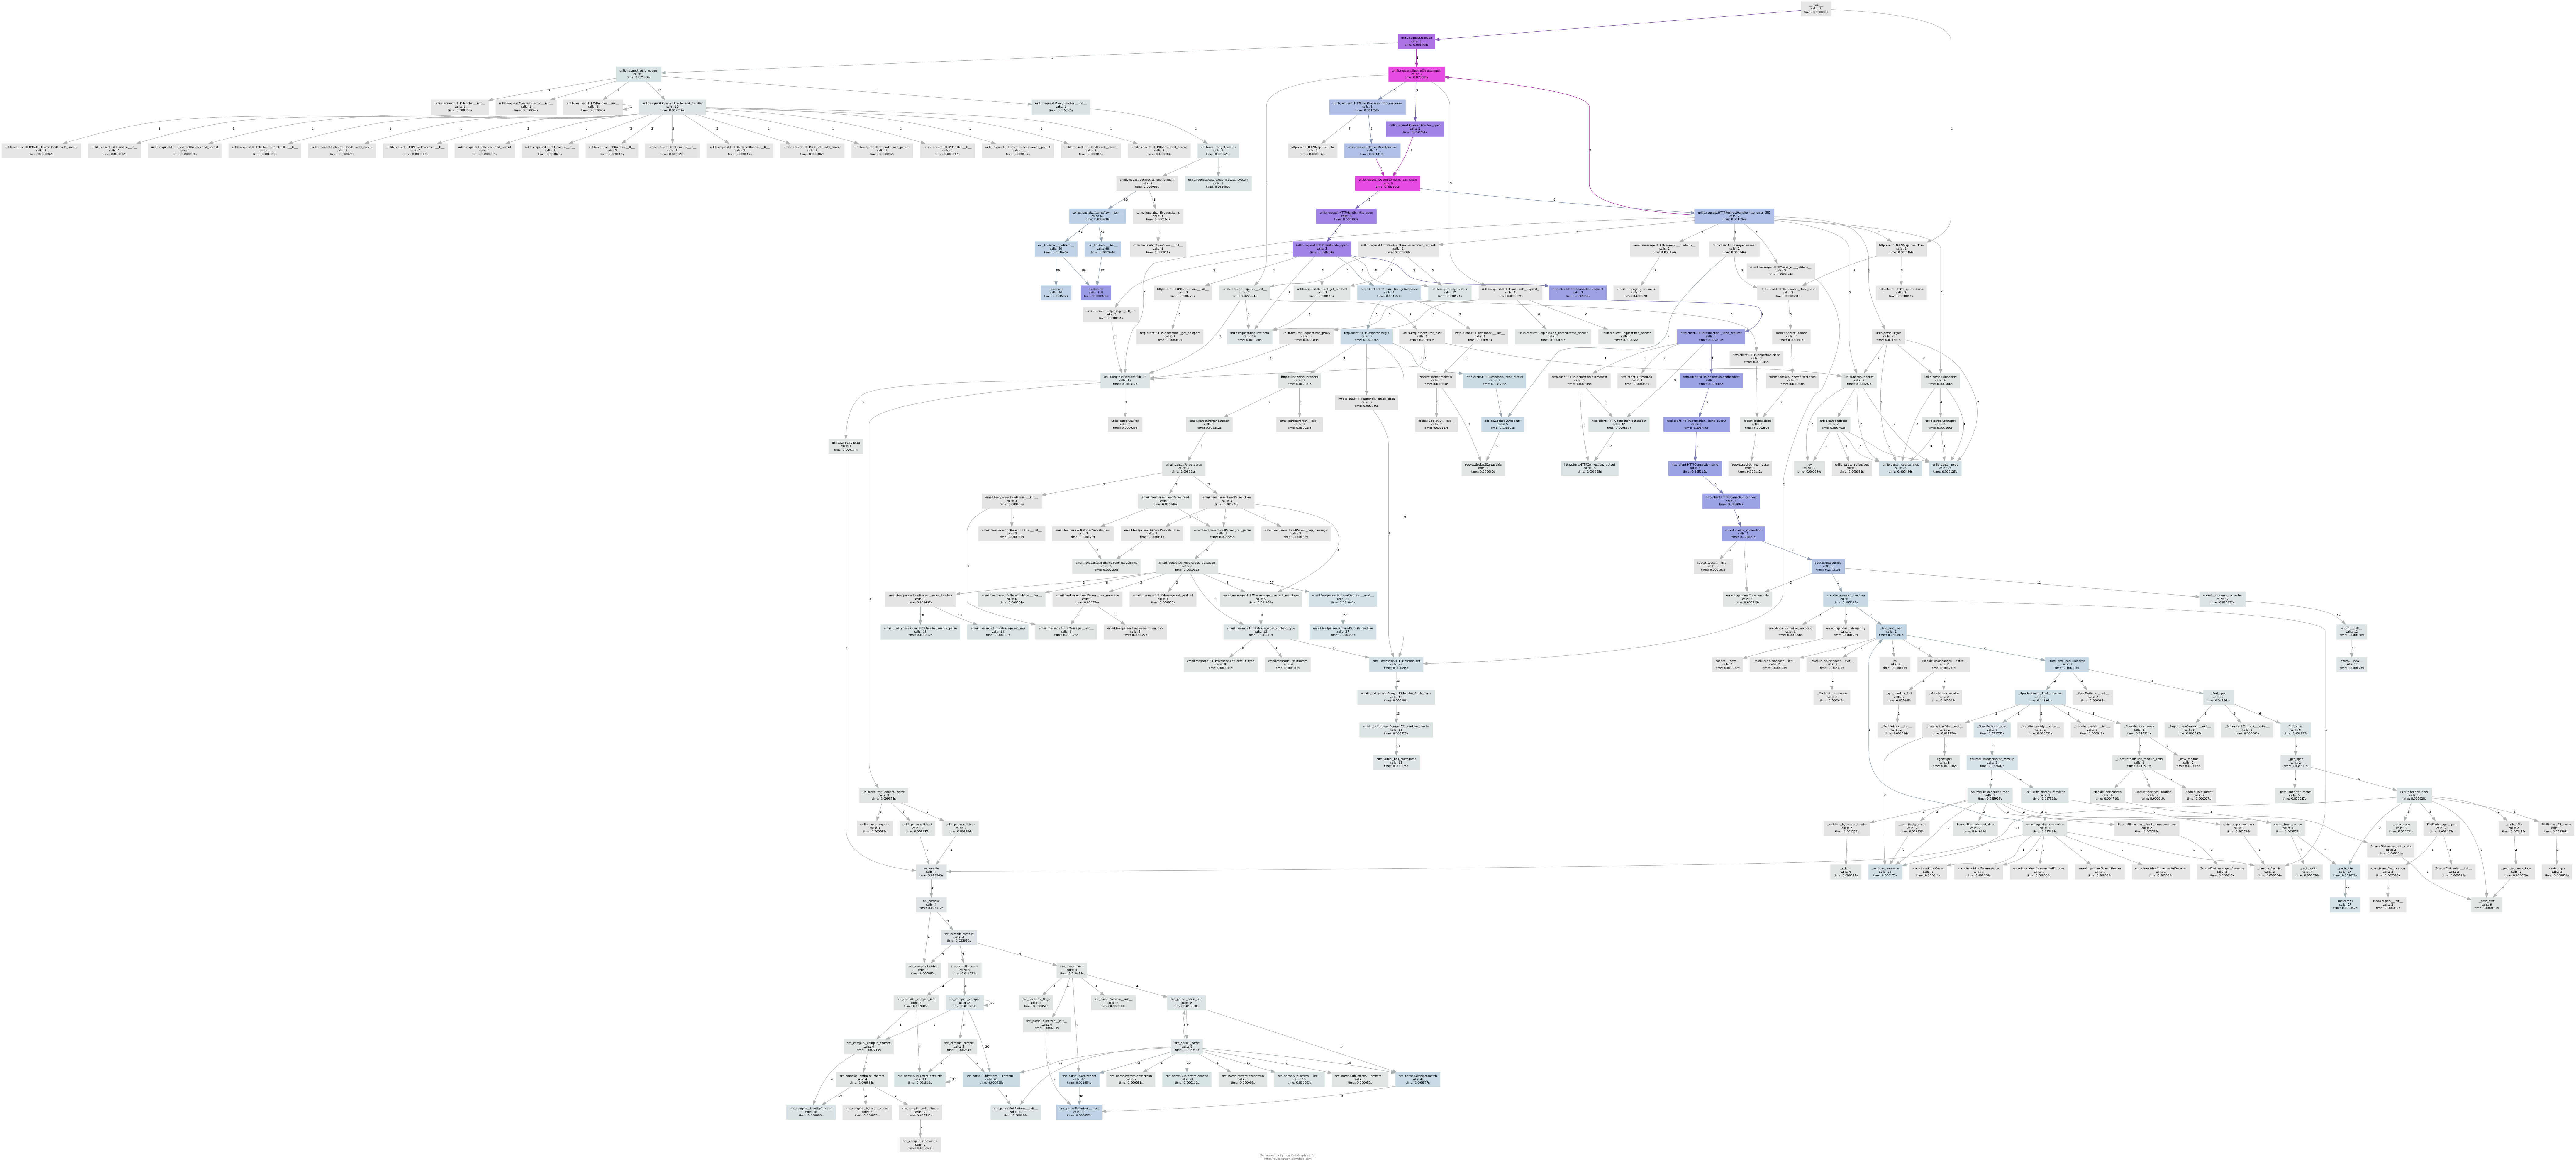

In [ ]:
with PyCallGraph(config=config, output=output):
    urllib.request.urlopen('http://matplotlib.org/') 
    
Image(filename='callgraph.png') 

That's something to stare at for a while! Ready for the big one now? Let's do it!

First, we're going to add a configuration option for just returning calls from the modules we care about.

Next, you should still have ``main()`` defined from above -- go ahead and run it:

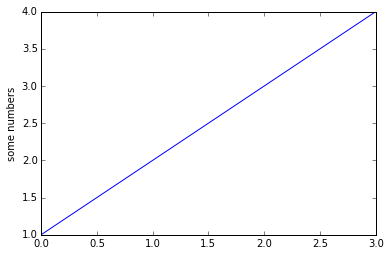

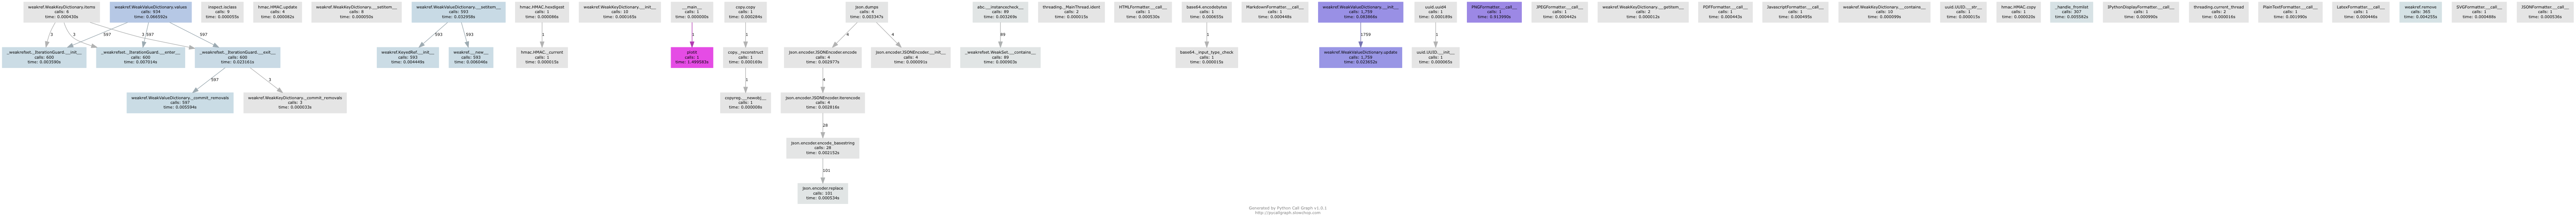

In [ ]:
with PyCallGraph(config=config, output=output):
    import matplotlib.pyplot as plt
    
    def plotit():
        plt.plot([1,2,3,4])
        plt.ylabel('some numbers')
        plt.show()
        
    plotit()

Image(filename='callgraph.png') 

## ``trace``

Since we can't seem to get pycallgraph to render calls into matplotlib, let's take a look at the tracing module instead. This next one may take a few minutes, depending upon your machine:

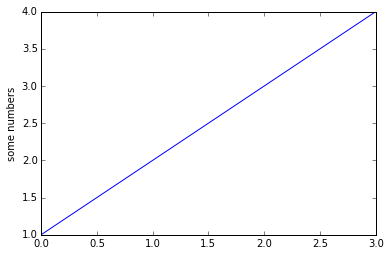

In [ ]:
def plotit():
    plt.plot([1,2,3,4])
    plt.ylabel('some numbers')
    plt.show()

tracer = trace.Trace(countfuncs=1, countcallers=1)
_ = tracer.runfunc(plotit)

In [ ]:
results = tracer.results()
_ = results.write_results(show_missing=True, summary=True, coverdir=".")


calling relationships:

*** /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/base64.py ***
    base64.encodebytes -> base64._input_type_check

*** /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/copy.py ***
  --> /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/copyreg.py
    copy._reconstruct -> copyreg.__newobj__
    copy.copy -> copy._reconstruct

*** /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/hmac.py ***
    hmac.HMAC.hexdigest -> hmac.HMAC._current

*** /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/json/__init__.py ***
  --> /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/json/encoder.py
    __init__.dumps -> encoder.JSONEncoder.__init__
    __init__.dumps -> encoder.JSONEncoder.encode

*** /Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/json/encoder.py ***
    encoder.JSONEncoder.encode -> encoder.JSONEncoder.iterencode
    encoder.JSONEncoder.iterencode -> encode